<a href="https://colab.research.google.com/github/Sridhar1101/Stock-Market-Portfolio-Optimisation/blob/main/Stock_Market_Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 pip install yfinance

In [13]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta


end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")


tickers = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS']

data = yf.download(tickers, start=start_date, end=end_date, progress=False)


data = data.reset_index()


data_melted = data.melt(id_vars=['Date'], var_name=['Attribute', 'Ticker'])


data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first')


stock_data = data_pivoted.reset_index()

print(stock_data.head())

Attribute       Date       Ticker    Adj Close        Close         High  \
0         2023-07-13  HDFCBANK.NS  1618.991943  1641.099976  1657.449951   
1         2023-07-13      INFY.NS  1340.103760  1365.099976  1376.800049   
2         2023-07-13  RELIANCE.NS  2522.876221  2531.788086  2583.476074   
3         2023-07-13       TCS.NS  3284.089355  3340.550049  3367.449951   
4         2023-07-14  HDFCBANK.NS  1622.346191  1644.500000  1653.599976   

Attribute          Low         Open      Volume  
0          1638.050049  1656.699951  20956773.0  
1          1330.849976  1334.900024   9977644.0  
2          2526.480957  2569.538818   7341467.0  
3          3272.750000  3284.000000   4585146.0  
4          1635.000000  1653.599976  12363607.0  


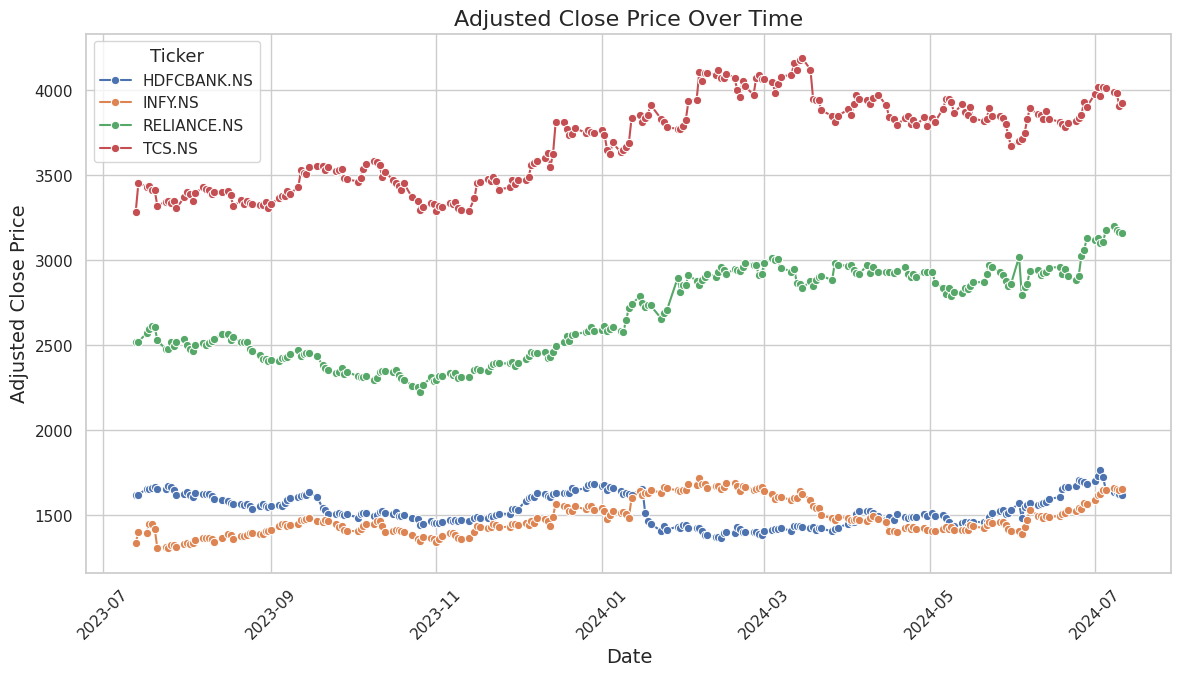

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

stock_data['Date'] = pd.to_datetime(stock_data['Date'])

stock_data.set_index('Date', inplace=True)
stock_data.reset_index(inplace=True)
plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

sns.lineplot(data=stock_data, x='Date', y='Adj Close', hue='Ticker', marker='o')

plt.title('Adjusted Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)

plt.xticks(rotation=45)

plt.show()

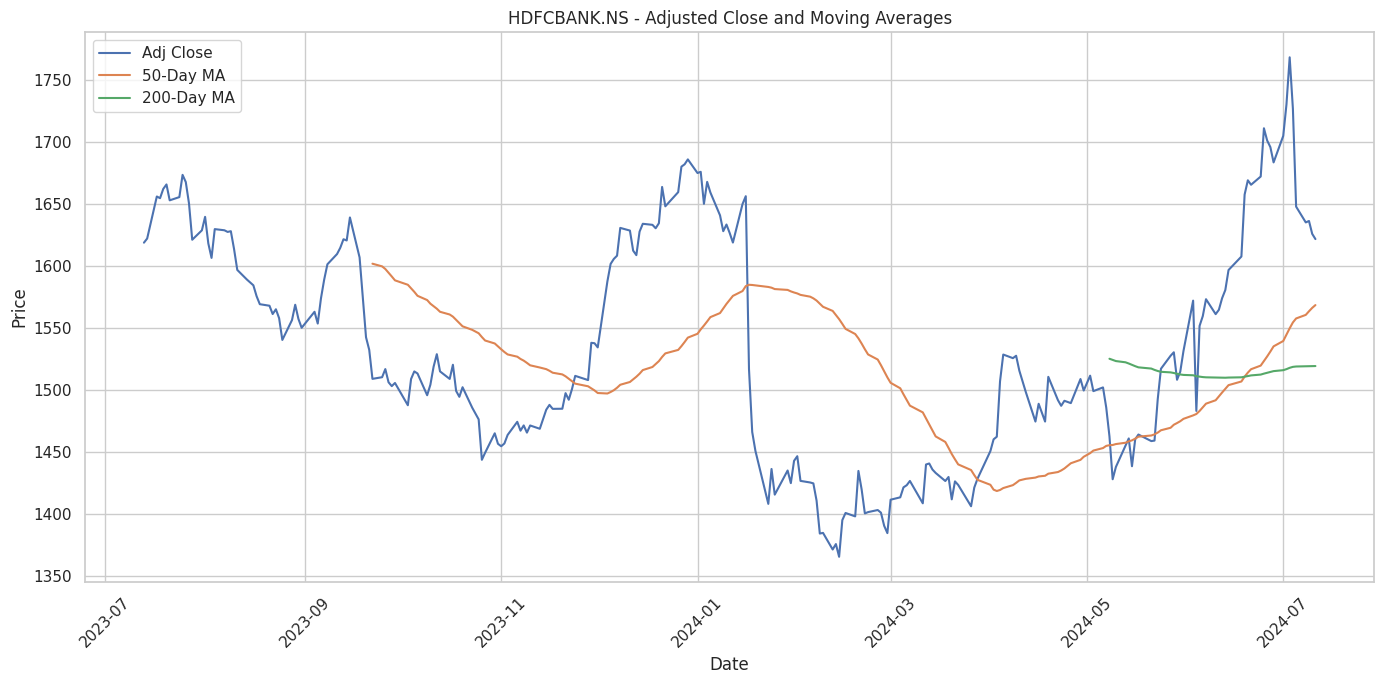

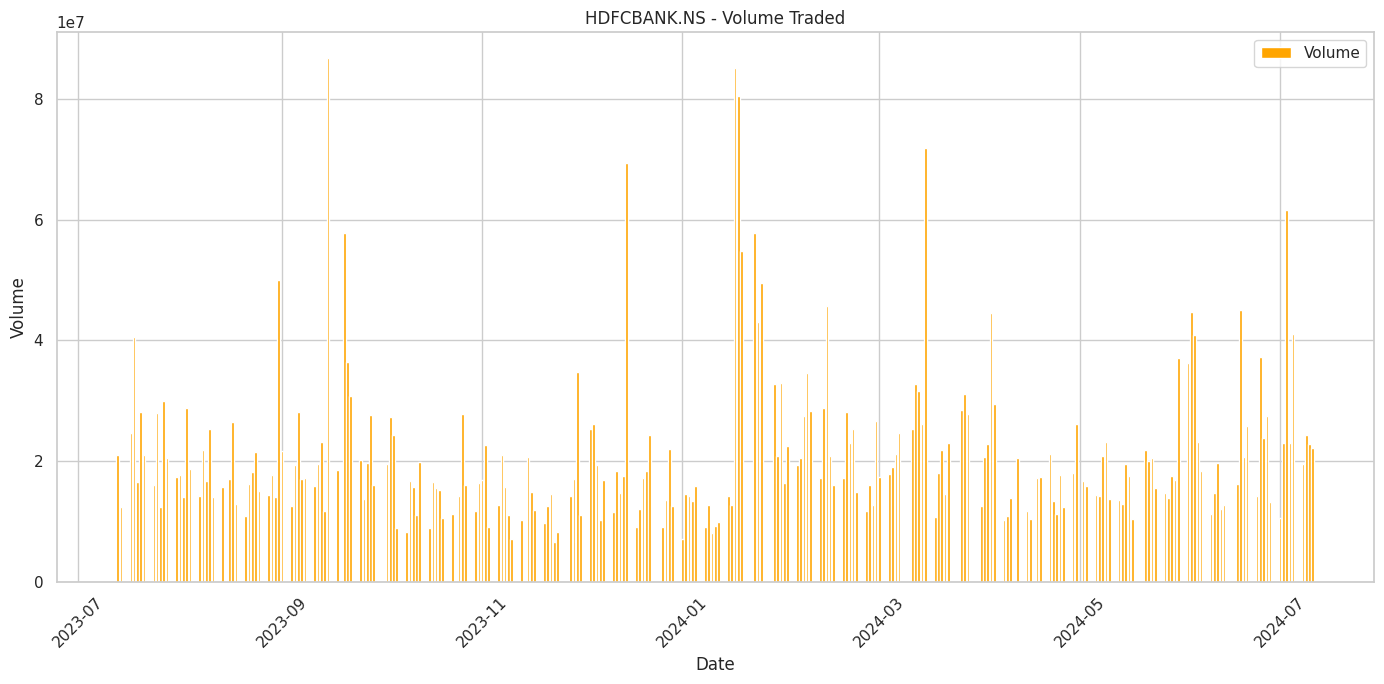

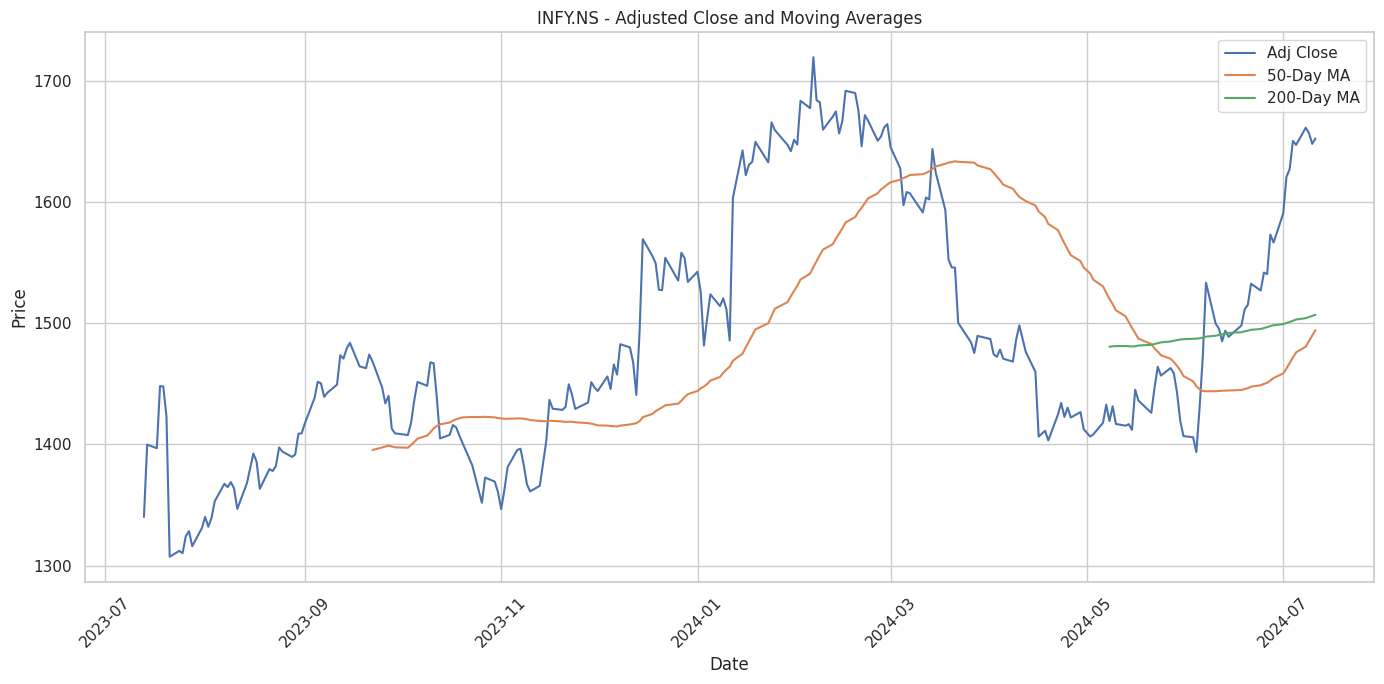

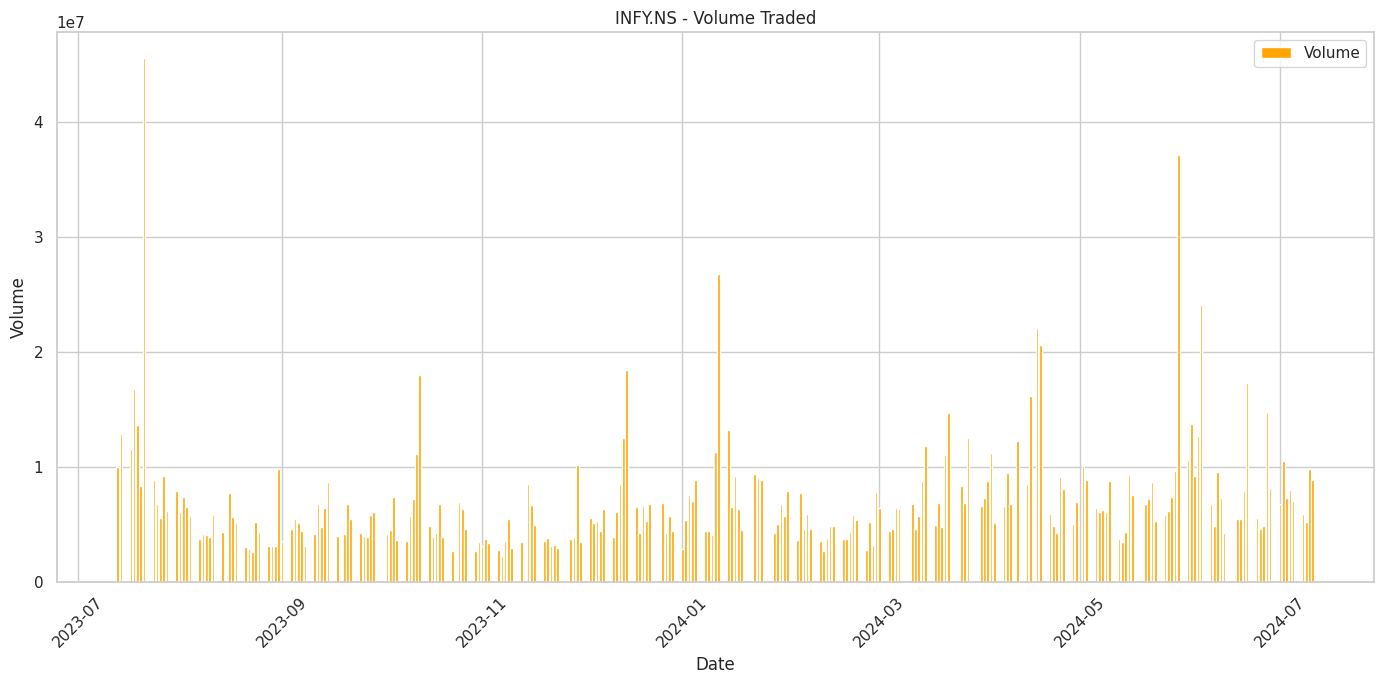

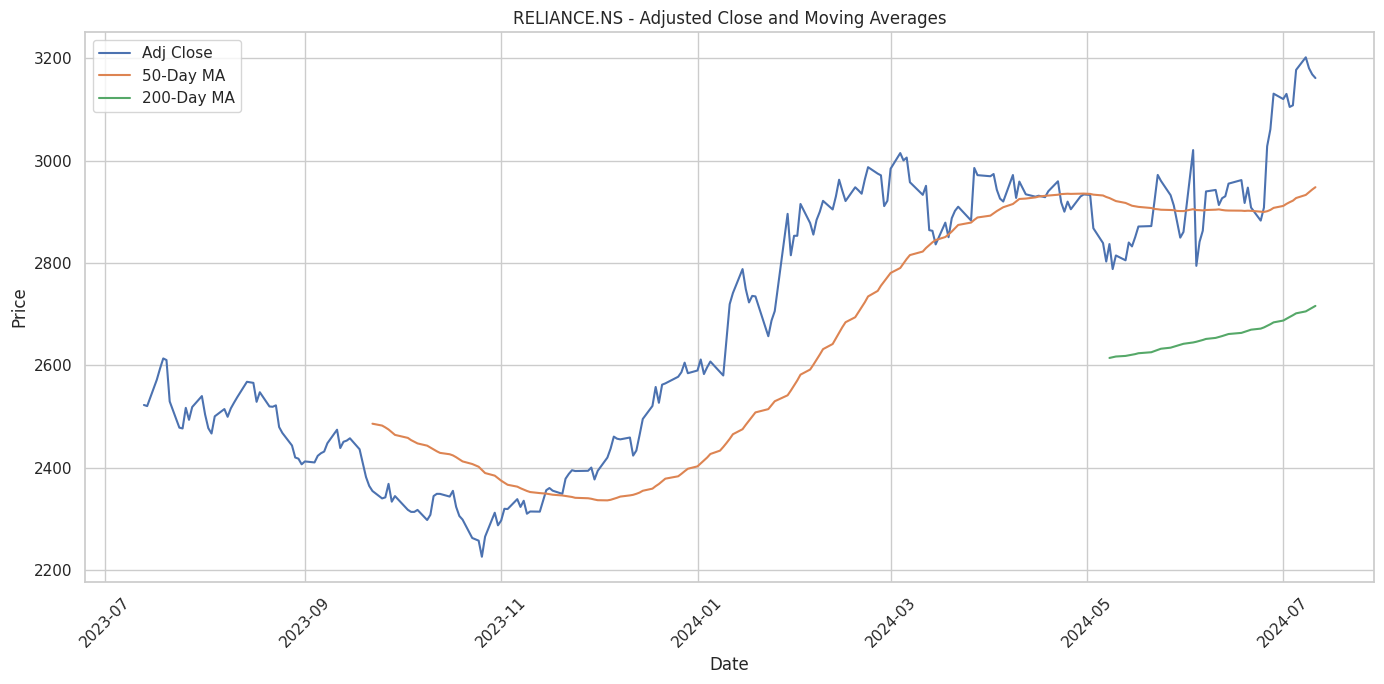

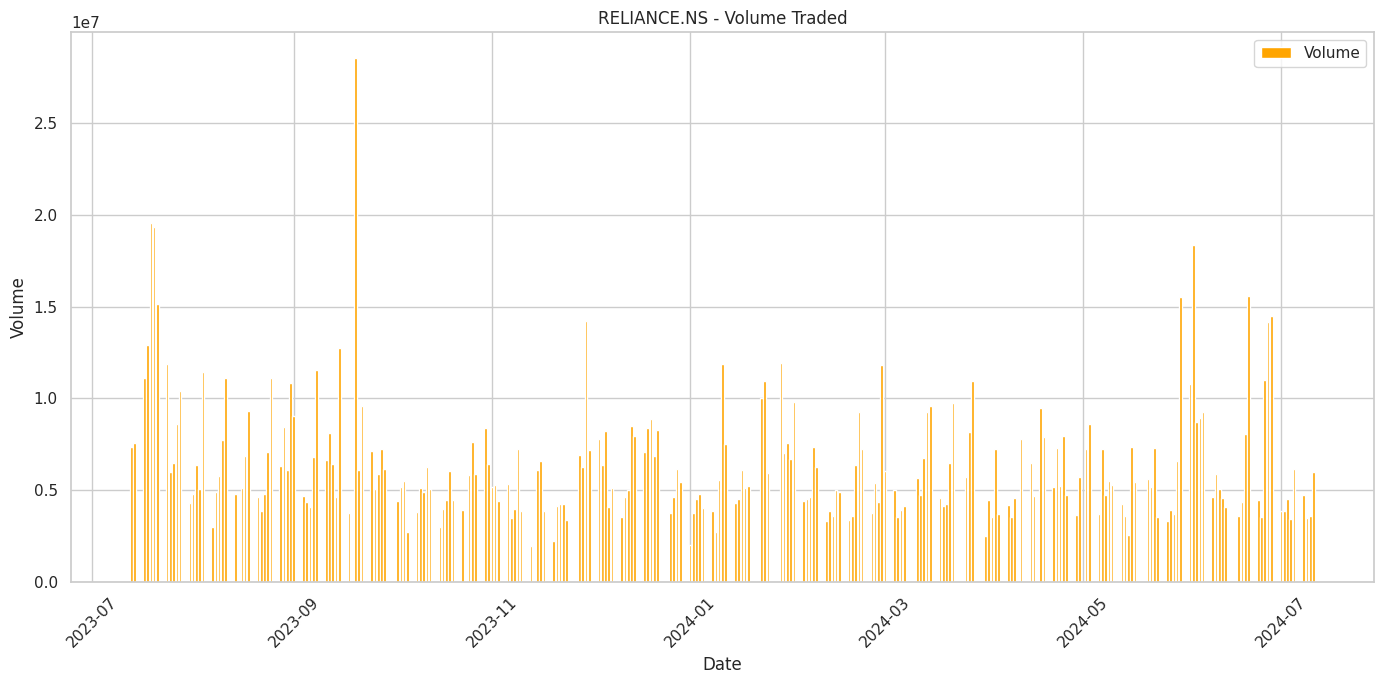

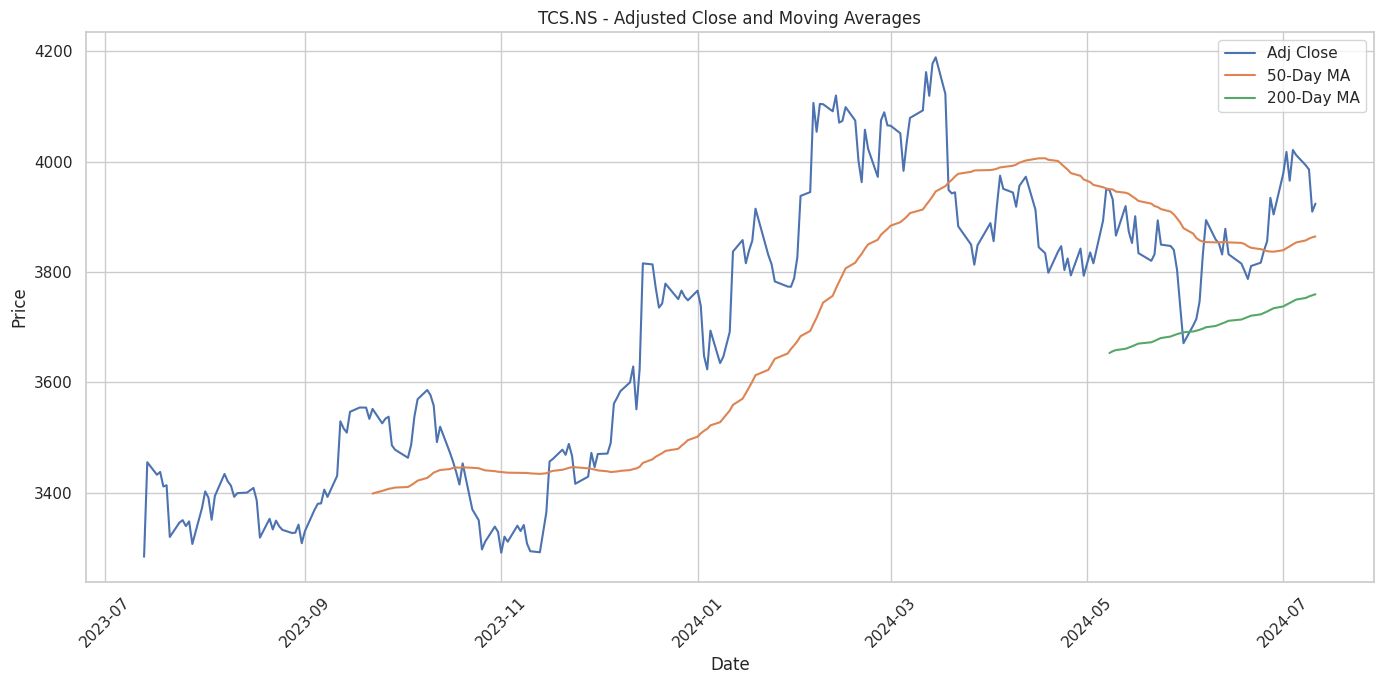

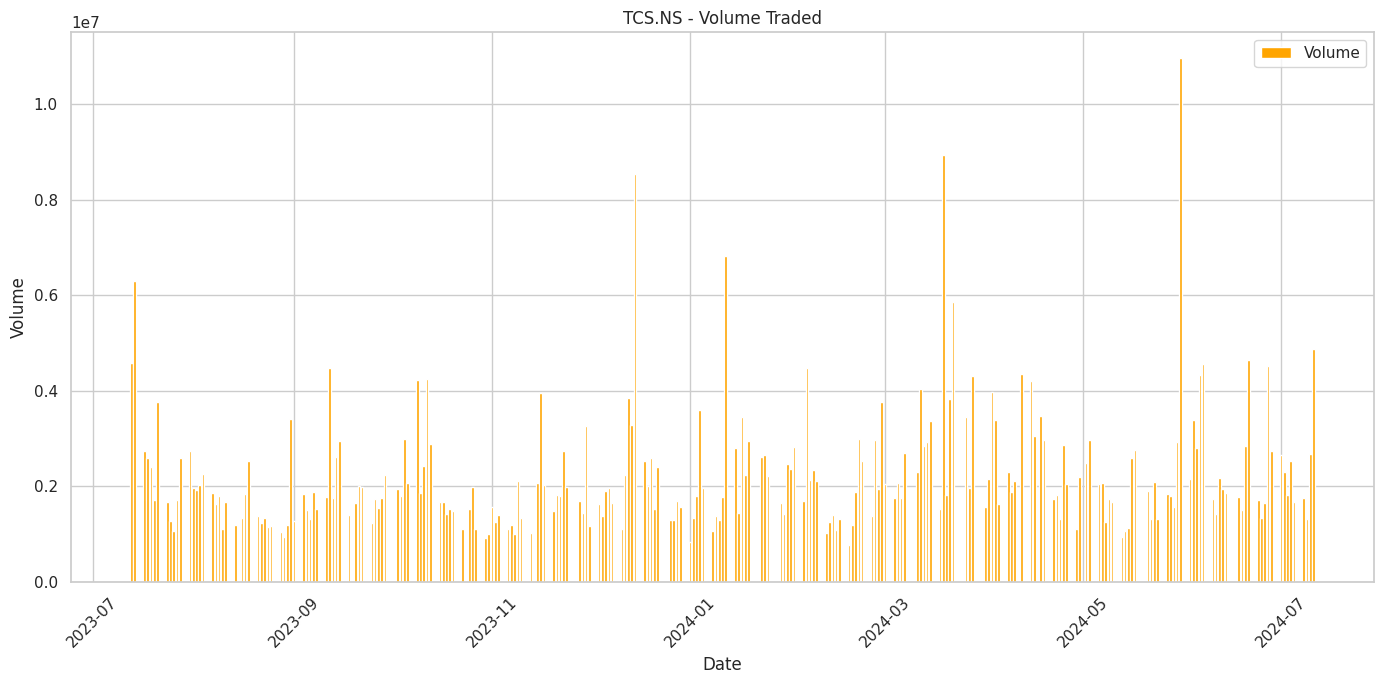

In [4]:
short_window = 50
long_window = 200

stock_data.set_index('Date', inplace=True)
unique_tickers = stock_data['Ticker'].unique()

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
    ticker_data['50_MA'] = ticker_data['Adj Close'].rolling(window=short_window).mean()
    ticker_data['200_MA'] = ticker_data['Adj Close'].rolling(window=long_window).mean()

    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data.index, ticker_data['Adj Close'], label='Adj Close')
    plt.plot(ticker_data.index, ticker_data['50_MA'], label='50-Day MA')
    plt.plot(ticker_data.index, ticker_data['200_MA'], label='200-Day MA')
    plt.title(f'{ticker} - Adjusted Close and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.bar(ticker_data.index, ticker_data['Volume'], label='Volume', color='orange')
    plt.title(f'{ticker} - Volume Traded')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

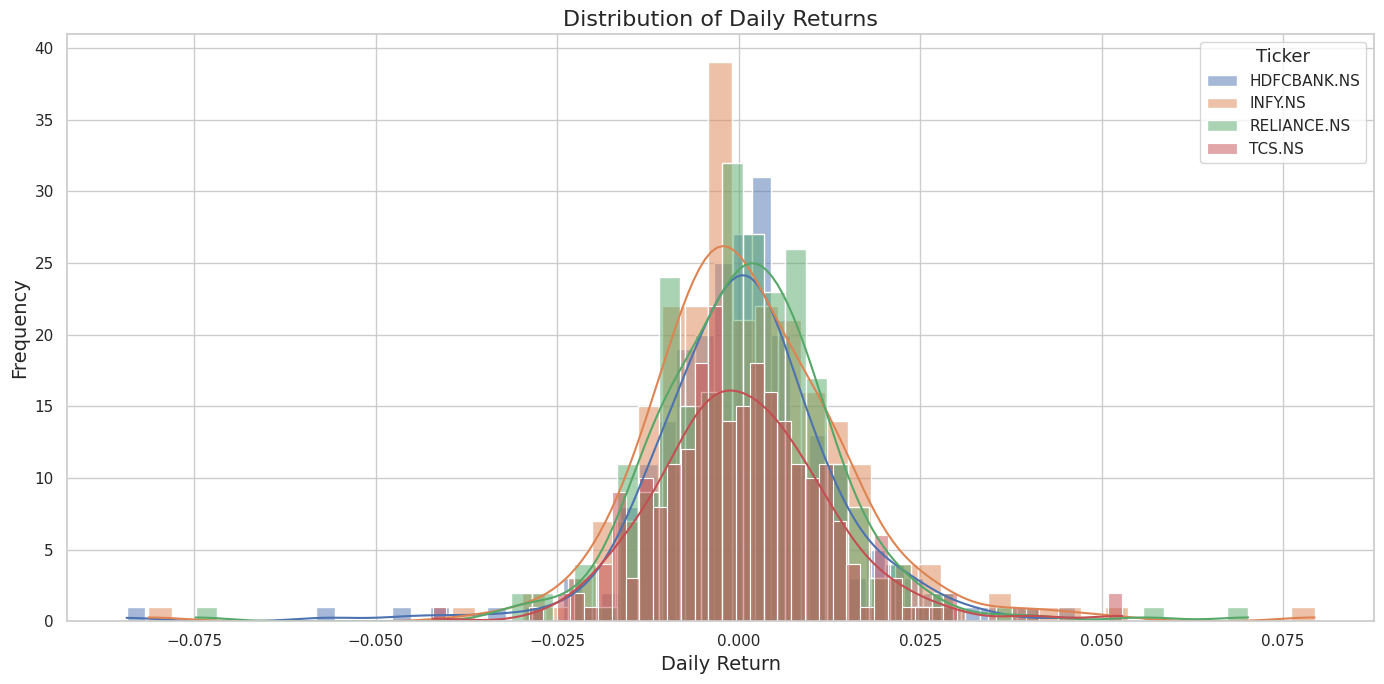

In [6]:
stock_data['Daily Return'] = stock_data.groupby('Ticker')['Adj Close'].pct_change()

plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker]
    sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, label=ticker, alpha=0.5)

plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.tight_layout()
plt.show()

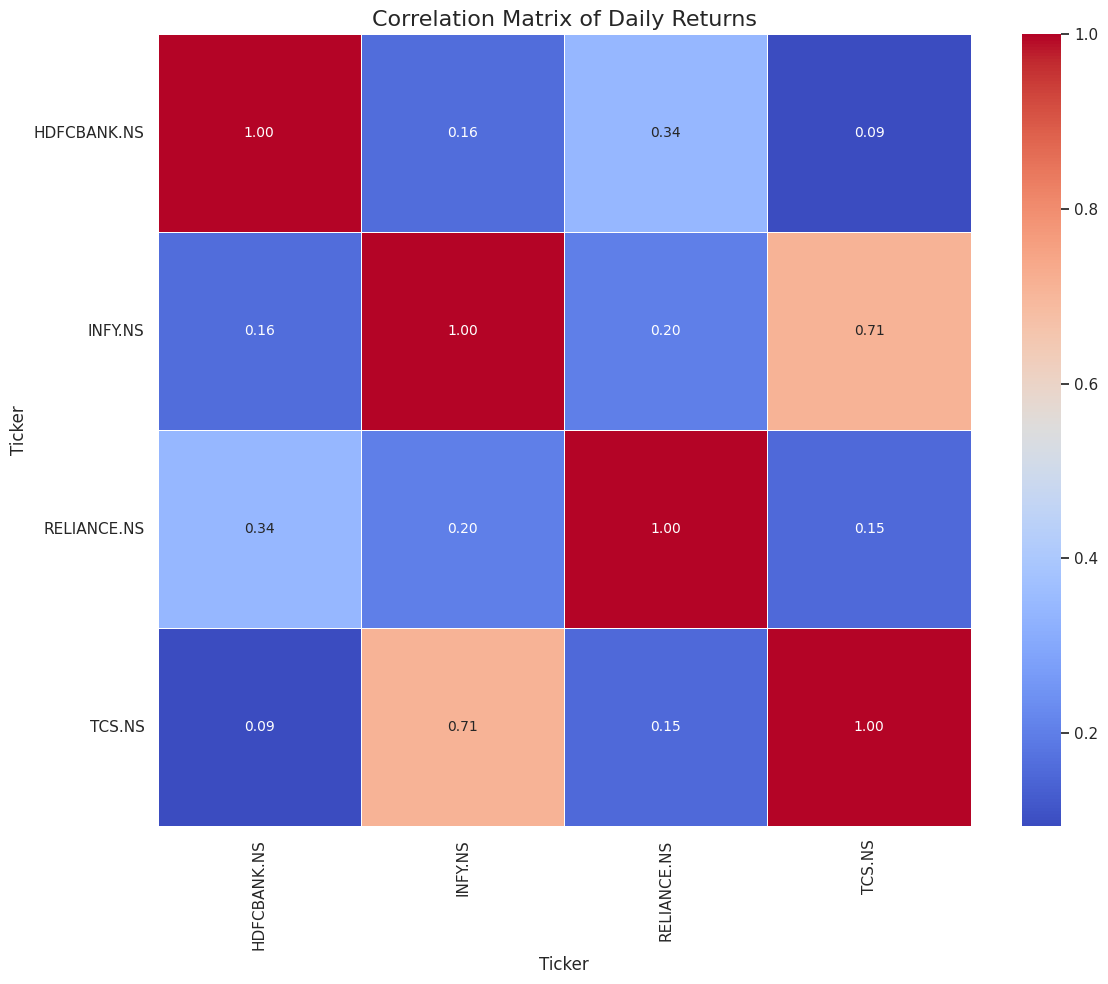

In [7]:
daily_returns = stock_data.pivot_table(index='Date', columns='Ticker', values='Daily Return')
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(12, 10))
sns.set(style='whitegrid')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [8]:
import numpy as np

expected_returns = daily_returns.mean() * 252
volatility = daily_returns.std() * np.sqrt(252)

stock_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Volatility': volatility
})

stock_stats

,Expected Return,Volatility
Ticker,,
HDFCBANK.NS,0.024588,0.212364
INFY.NS,0.244088,0.231298
RELIANCE.NS,0.256119,0.210686
TCS.NS,0.203808,0.196985


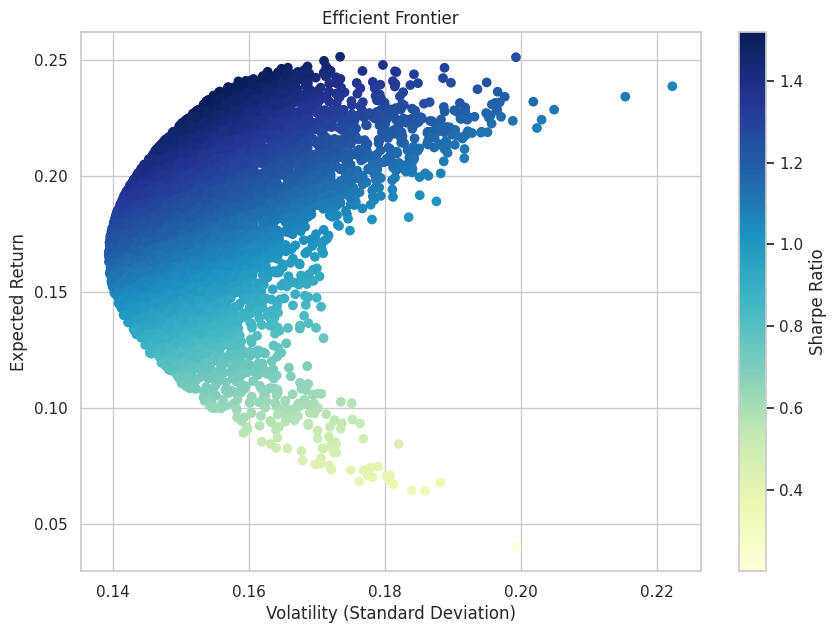

In [9]:

def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility


num_portfolios = 10000


results = np.zeros((3, num_portfolios))

cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility  # Sharpe Ratio

plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

In [10]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio

(0.24065843358989975, 0.15847126429746697, 1.518625062132141)

In [11]:
max_sharpe_weights = np.zeros(len(unique_tickers))

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'Weight': max_sharpe_weights
})

portfolio_weights_df

,Ticker,Weight
0,HDFCBANK.NS,0.229701
1,INFY.NS,0.291280
2,RELIANCE.NS,0.084538
3,TCS.NS,0.394481
